In [1]:
import matplotlib
%matplotlib inline

import PreFRBLE
from PreFRBLE.convenience import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *


# Basic Usage

Here we explain the basic usage of PrEFRBLE:
1. How to read likelihood functions of individual models and realistic LoS scenarios
2. How to add likelihood functions of new models
3. How to compute the likelihood of measurements in a scenario as well as the Bayes Factor

## Read Likelihood

We start with reading and plotting the likelihood function $P$ of an individual model.
$P$ (100-array) is the probability density of given measure.
$x$ (101-array) is the range of bins in measure corresponding to the values of $P$.
$P$ is normalized such that $1 = \sum P \cdot \text{d}x$.
However, PlotLikelihood by default plots $P\cdot x$, thus the shape is identical to the probability of measures, while the displayed values are physical and do not depend on the binning.
So far, all likelihood functions are written with logarithmic bin ranges.

1.0000000000000004


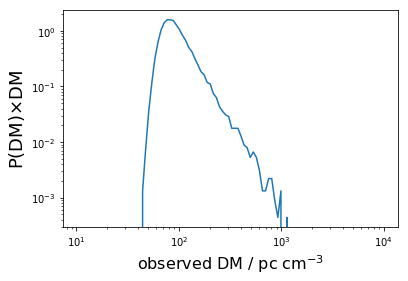

In [16]:
measure = 'DM'
model = 'primordial'
redshift = 0.1

P, x = GetLikelihood_IGM( measure=measure, model=model, redshift=redshift )

PlotLikelihood( P=P, x=x, measure=measure )
print( np.sum( P*np.diff(x) ) )

Similar functions exist for the other regions: Host, Inter, Local and MilkyWay. 
Another more general way to read the same Likelihood function is the following, which also allows to read out the deviation according to shot noise of the Monte-Carlo simulation

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:762: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


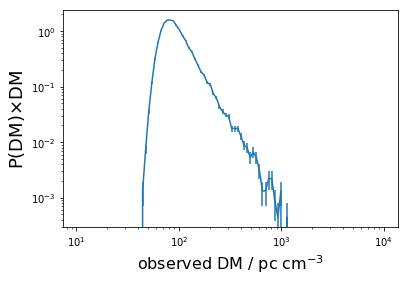

In [14]:
P, x, dev = GetLikelihood( measure=measure, redshift=redshift, region='IGM', model=model, dev=True )
PlotLikelihood( P=P, x=x, dev=dev, measure=measure )

In order to investigate realistic scenarios for full LoS, we convolve the likelihoods of measure in the different regions, e. g. 
$$ P(x) = P_1 \ast P_2 (x) = \int P_1(y) P_2(x-y) \text{d}y . $$
To read the resulting likelihood, we first need to define a scenario

In [7]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18/smd'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
}

scenario_local = {
    'Local' : ['Piro18/wind'],
}

scenario = {
    'IGM' : ['primordial'],
    'Host': ['Heesen11/dirty'],
#    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}

With this, we can read out the full likelihood using the following (can take a little while if it hasn't been computed yet, especially for non-absolute measures like RM.)

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:762: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:281: RuntimeWarning: invalid value encountered in true_divide
  dev = np.sqrt(dev0 + dev1) / P


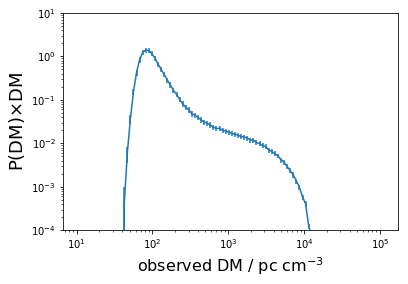

In [12]:
P, x, dev = GetLikelihood_Full( measure=measure, redshift=redshift, dev=True, **scenario )

PlotLikelihood( P=P, x=x, dev=dev, measure=measure )
plt.ylim(1e-4,10)
plt.show()

In order to compare these predictions to observations made by telescopes, we have to consider the selection effects of the instrument and assume an intrinsic redshift distribution of FRBs. 
The estimated likelihood of measure is obtained by summing results of all redshifts, weighted by the expected amount of FRBs from that redshift, e. g.
$$
P(DM|tele) = \int P(DM|z) P(z|tele) \text{d}z .
$$ 
This is done using [FRBpoppy](https://github.com/davidgardenier/frbpoppy/tree/master/frbpoppy). 
The result can be read out using

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:762: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5
  0%|          | 0/60 [00:00<?, ?it/s]/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:281: RuntimeWarning: invalid value encountered in true_divide
  dev = np.sqrt(dev0 + dev1) / P
100%|██████████| 60/60 [01:40<00:00,  1.67s/it]
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:173: RuntimeWarning: invalid value encountered in double_scalars
  dev[ib] += add**2 * ( np.sum( ( devs[i_f][ix]*f[ix]*np.diff(x_) )**2 ) /np.sum( ( f[ix]*np.diff(x_) )**2 )  + dev_weights[i_f]**2 )


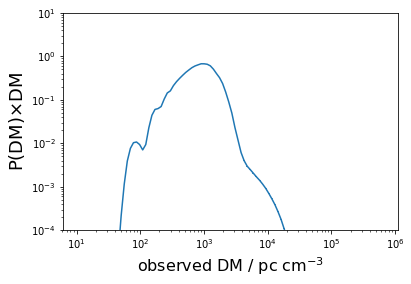

In [18]:
telescope = 'CHIME'
population = 'SMD' ## for redshift distribution to follow Stellar Mass Density

P, x, dev = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, dev=True, **scenario )

PlotLikelihood( P=P, x=x, dev=dev, measure=measure )
plt.ylim(1e-4,10)
plt.show()

This plot can be compared directly to the distribution of observed measures.

More convenient functions concerning likelihood functions can be found in the PreFRBLE_Likelihood notebook

## Write New Likelihood

We can easily add another model for individual regions, e. g. using 

In [ ]:
# data = [P, x ]
# keys = [ KeyLocal( model='dummy', measure, axis=axis )  for axis in ['P','x'] ]
Write2h5( likelihood_file_local, data, keys )

New likelihood functions have to match the form stated above, directly under Read Likelihood.
These likelihood functions can either be analytical description of $P$ or can be obtained from a model of the region e. g. via Monte-Carlo simulation.
To obtain the likelihood function from the resulting sample, simply use

In [ ]:
measures = np.random.rand(100)

P, x = Likelihood( data=measures, bins=100, log=True, density=True )

You can find a few examples on the models derived so far in the model subdirectory.

## Compute Model Likelihood

Say we have a number of observations and want to see how likely they are assuming a certain scenario.
For this, we have to indicate the observing telescope, assume a population and define the scenario in question.
For this, we read the likelihood distribution $P$ expected to be observed and obtain the corresponding values of $P$ for the observed measures

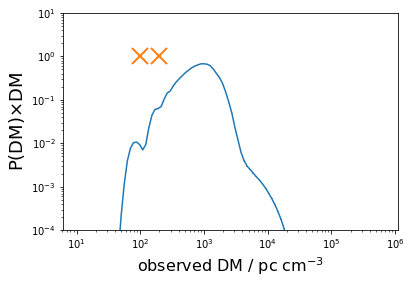

[0.00104058 0.00698908]


In [41]:
measure='DM'
measures = [1e2, 2e2]

telescope = 'CHIME'

population = 'SMD' ## for redshift distribution to follow Stellar Mass Density
scenario = {
    'IGM' : ['primordial'],
    'Host': ['Heesen11/dirty'],
    'Local': ['Piro18/wind'], 
}

P0, x0, dev0 = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, dev=True, **scenario )

PlotLikelihood( P=P0, x=x0, dev=dev0, measure=measure )
plt.plot( measures, [1]*len(measures), marker='x', markersize=16, markeredgewidth=2, linestyle=' ' )
plt.ylim(1e-4,10)
plt.show()

L0 = Likelihoods( measurements=measures, P=P0, x=x0, dev=dev )
print(L0[0])

In order to compute the Bayes factor
$$
\mathcal{B} = \frac{P_0}{P_1}
$$
we do the same for a competing scenario and compute the ratio of $P$.

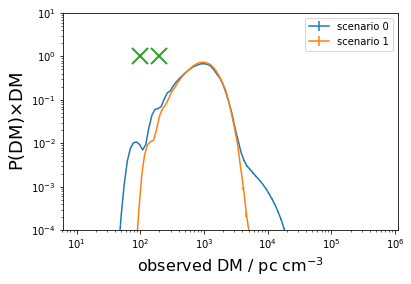

[0.00019471 0.00468506]
Bayes = 7.972240, hence scenario 0 is this much more likely to explain the measures


In [43]:
scenario = {
    'IGM' : ['primordial'],
    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}

fig, ax = plt.subplots()

PlotLikelihood( P=P0, x=x0, dev=dev0, measure=measure, label='scenario 0', ax=ax )


P1, x1, dev1 = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, dev=True, **scenario )

PlotLikelihood( P=P1, x=x1, dev=dev1, measure=measure, label='scenario 1', ax=ax  )
ax.plot( measures, [1]*len(measures), marker='x', markersize=16, markeredgewidth=2, linestyle=' ' )
ax.set_ylim(1e-4,10)
ax.legend()
plt.show()

L1 = Likelihoods( measurements=measures, P=P1, x=x1, dev=dev1 )
print(L1[0])
print('Bayes = %f, hence scenario 0 is this much more likely to explain the measures' % (np.prod( L0[0]/L1[0] )))

You can find more applications in the notebooks starting with PreFRBLE_*